In [1]:
# fastai 0.7.2, kinda worked - downloaded into a folder. But then dunno how to import and use it properly...
#!pip install -e git+https://github.com/fastai/fastai1@e85667cfae2e6873b1bb026195b5d09a74dfcff9#egg=fastai07
#%load_ext autoreload
#%autoreload 2
#%matplotlib inline

In [2]:
#!pip install fastai==0.7.0 --no-deps
#!pip install scikit-learn==0.21.3
# fastai depends also on an older version of torch
#!pip install torch==0.4.1 torchvision==0.2.1
#!pip show fastai

In [3]:
#!pip install treeinterpreter
#!pip install waterfallcharts

In [4]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

df = pd.read_csv('heroes-of-the-storm-matches-sample/export_flat_form.csv')

In [6]:
def split_vals(a,n): 
    return a[:n].copy(), a[n:].copy()

def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

### Preprocessing
Check info on the events, i.e. date range, plot date distribution to get a clearer view about the data, then drop the date column entirely since it is useless information for our models.

In [7]:
df.date = pd.to_datetime(df["date"])
dates_ordinal = pd.Series([x.toordinal() for x in df.date])

First check the dates and filter the ones that would be too old for us to be usable.

[Text(737200.0, 0, '2019-05-21'),
 Text(737400.0, 0, '2019-12-07'),
 Text(737600.0, 0, '2020-06-24'),
 Text(737800.0, 0, '2021-01-10'),
 Text(738000.0, 0, '2021-07-29')]

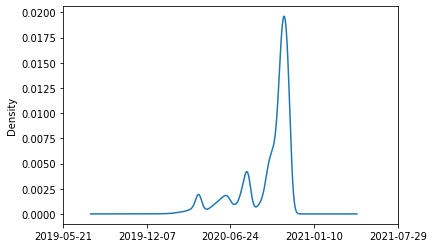

In [8]:
# plot non-parametric kde on numeric datenum
ax = dates_ordinal.plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
xlabels = [datetime.datetime.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

let's keep just last 5 months dates

In [9]:
#see if there are any missing values

In [10]:
dates_mask = (df.date > '2020-10-01')
df_newer_dates = df.loc[dates_mask]
dates_ordinal_newer = pd.Series([x.toordinal() for x in df_newer_dates.date])

[Text(737660.0, 0, '2020-08-23'),
 Text(737700.0, 0, '2020-10-02'),
 Text(737740.0, 0, '2020-11-11'),
 Text(737780.0, 0, '2020-12-21')]

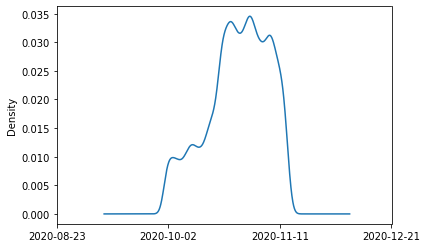

In [11]:
# plot non-parametric kde on numeric datenum
ax = dates_ordinal_newer.plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
xlabels = [datetime.datetime.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

In [12]:
min_date = df.date.min()
max_date = df.date.max()
print("older match: "+ str(min_date)+"   newest match: "+str(max_date))

older match: 2020-01-01 00:54:03   newest match: 2020-11-14 12:54:01


In [13]:
min_date = df_newer_dates.date.min()
max_date = df_newer_dates.date.max()
print("older match: "+ str(min_date)+"   newest match: "+str(max_date))

older match: 2020-10-01 00:02:11   newest match: 2020-11-14 12:54:01


In [14]:
sample_size = 5000 #30000

In [15]:
df_raw = df_newer_dates.drop(columns=['date'])
print(df_raw.shape)
df_raw = df_raw.sample(n = sample_size, random_state = 1, axis = 0)
print(df_raw.shape)
df_raw.reset_index(drop=True, inplace=True)
#print(df_raw.tail())

(45855, 13)
(5000, 13)


In [16]:
invert_ratio = 0.5
n_inv = int(len(df_raw) * invert_ratio)
df_standard, df_inverted = split_vals(df_raw, n_inv)
#print(df_inverted.head())
df_inverted = df_inverted.rename(columns={"winnerA": "loserA", "winnerB": "loserB", "winnerC": "loserC", "winnerD": "loserD", "winnerE": "loserE",
                            "loserA": "winnerA", "loserB": "winnerB", "loserC": "winnerC", "loserD": "winnerD", "loserE": "winnerE"})
#df.loc[idx] = df.loc[idx].rename(columns={'R':'L','L':'R'})
df_inverted['outcome'] = 0
df_mixed = df_standard.append(df_inverted)
#print(df_mixed.head())
#print(df_mixed.tail())
df_mixed.outcome.mean()

0.5

In [17]:
train_cats(df_mixed)
print([len(df_mixed[x].cat.categories) for x in df.columns[1:13]])

[14, 2, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87]


### if it throws error here, it means tables were cleared, need to re-run from the import of csv:

In [18]:

hero_names = df_mixed['winnerA'].cat.categories
heroes_total = max(hero_names)
map_names = df_mixed['game_map'].cat.categories

print([len(df_mixed[x].cat.categories) for x in df.columns[1:13]], "  heroes_total =", heroes_total)
print(hero_names[:9], "...")
#df_mixed.dtypes

[14, 2, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87]   heroes_total = Zul'jin
Index(['Abathur', 'Alarak', 'Alexstrasza', 'Ana', 'Anduin', 'Anub'arak',
       'Artanis', 'Arthas', 'Auriel'],
      dtype='object') ...


In [19]:
#clear up memory:
dates_ordinal_newer = 0
dates_ordinal = 0
df = pd.DataFrame()
df_raw = pd.DataFrame()
df_standard = pd.DataFrame()
df_inverted = pd.DataFrame()

Great, shuffling worked. Another problem is the format of the table itself. We are more interested in relations between features more than anything else, therefore let's transform the table into something mode understandable for the Tree type model. For that, the first idea to try - split the features into "multiple-hot" encoding table. Not sure if this is even a thing, but let's try that. A one-hot encoder would give us a great start, so let's use that.

In [20]:
winner_cols = ['winnerA', 'winnerB', 'winnerC', 'winnerD', 'winnerE']
loser_cols = ['loserA', 'loserB', 'loserC', 'loserD', 'loserE']
dummies_data = pd.DataFrame(columns = hero_names, dtype = 'int8')

In [21]:
def hero_hot_transform(game_map = '', game_type = 'UnrankedDraft', winners = [], losers = [], bans = []):
    new_row = pd.Series(index = hero_names, dtype = 'int8')
    for x in hero_names:
        if x in winners:
            new_row[x] = 2
        if x in losers:
            new_row[x] = 1
    game_map_index = df_mixed['game_map'].cat.categories.get_loc(game_map) 
    game_type_index = df_mixed['game_type'].cat.categories.get_loc(game_type)        

    #print(dict( enumerate(df_mixed['game_map'].cat.categories ) ))
    new_row = new_row.append(pd.Series([game_map_index, game_type_index], index = ['game_map','game_type']))
    return new_row

In [22]:
game_map = 'Garden of Terror'
game_type = 'UnrankedDraft'
winners=['Auriel', 'Muradin']
losers=['Illidian', 'Abathur']
row = [hero_hot_transform(game_map = game_map, game_type=game_type, winners = winners, losers=losers)]
row

[Abathur        1
 Alarak         0
 Alexstrasza    0
 Ana            0
 Anduin         0
               ..
 Zarya          0
 Zeratul        0
 Zul'jin        0
 game_map       6
 game_type      1
 Length: 89, dtype: int64]

In [23]:
for index in range(0, int(len(df_mixed))): #
    game_map = df_mixed['game_map'].iloc[index]
    game_type = df_mixed['game_type'].iloc[index]

    winners = list(df_mixed[winner_cols].iloc[index].astype(str))
    losers = list(df_mixed[loser_cols].iloc[index].astype(str))
    #bans =
    dummies_data = dummies_data.append(hero_hot_transform(game_map = game_map, game_type=game_type, winners = winners, losers = losers), ignore_index=True)

In [24]:
dummies_data.describe()

,Abathur,Alarak,Alexstrasza,Ana,Anduin,Anub'arak,Artanis,Arthas,Auriel,Azmodan,...,Varian,Whitemane,Xul,Yrel,Zagara,Zarya,Zeratul,Zul'jin,game_map,game_type
count,5000.00000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,0.12740,0.10560,0.107000,0.225200,0.310600,0.202400,0.260400,0.138000,0.131800,0.141000,...,0.243000,0.095000,0.16200,0.084600,0.067600,0.041200,0.110800,0.16980,6.361400,0.056000
std,0.44588,0.40704,0.410347,0.572145,0.647311,0.545796,0.600886,0.458474,0.456147,0.461261,...,0.593988,0.387305,0.49498,0.364787,0.327187,0.262138,0.413954,0.50894,3.673457,0.229945
min,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,4.000000,0.000000
50%,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,7.000000,0.000000
75%,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,9.000000,0.000000
max,2.00000,2.00000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,2.000000,2.00000,13.000000,1.000000


In [25]:
print('total mem: ', sum(dummies_data.memory_usage()) / 1000)
print(dummies_data.dtypes)

total mem:  3560.128
Abathur          int64
Alarak           int64
Alexstrasza      int64
Ana              int64
Anduin           int64
                ...   
Zarya            int64
Zeratul          int64
Zul'jin          int64
game_map       float64
game_type      float64
Length: 89, dtype: object


In [26]:
dummies_data = pd.concat([dummies_data, df_mixed[['outcome']]], axis = 1)

In [27]:
dummies_data.tail()

,Abathur,Alarak,Alexstrasza,Ana,Anduin,Anub'arak,Artanis,Arthas,Auriel,Azmodan,...,Whitemane,Xul,Yrel,Zagara,Zarya,Zeratul,Zul'jin,game_map,game_type,outcome
4995,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,11.0,0.0,0
4996,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,1,0,1.0,0.0,0
4997,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,2,8.0,0.0,0
4998,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,2,6.0,0.0,0
4999,0,0,0,0,0,0,0,0,2,2,...,0,0,0,0,0,0,0,8.0,0.0,0


## Prepare train and val sets

In [28]:
#need this again for new dataframe, cause we attached strings when transforming
#train_cats(dummies_data)

In [29]:
df_trn, y_trn, nas = proc_df(dummies_data, 'outcome')

In [30]:
train_required_ratio = 0.8
n_trn = int(len(df_trn) * train_required_ratio)
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
X_train.shape, X_valid.shape

((4000, 89), (1000, 89))

In [31]:
apply_cats(X_valid, X_train)

Start with simple and stupid

In [32]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 17.7 ms, sys: 107 µs, total: 17.8 ms
Wall time: 128 ms
[0.4790705298653392, 0.6224006676087814, 0.02076342363538397, 0.0]


In [33]:
#draw_tree(m.estimators_[0], df_trn, size = 20, precision=3)
#?draw_tree

### Try Out Bagging ?
dont remember what is it.. gotta read about it more

In [34]:
#preds = np.stack([t.predict(X_valid) for t in m.estimators_])
#preds[:,0], np.mean(preds[:,0]), y_valid[0]
#preds.shape

In [35]:
#plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

Subsampling

In [36]:
#set_rf_samples(2000) #if you set_rf_samples - cannot use OOB score, so dont put the parameter

In [37]:
#m = RandomForestRegressor(n_estimators=20, n_jobs=-1, oob_score=False)
#%time m.fit(X_train, y_train)
#print_score(m)

In [38]:
#reset_rf_samples()

In [39]:
#m = RandomForestRegressor(n_estimators=20, min_samples_leaf=3, n_jobs=-1, oob_score=False) #min_samples_leaf = 1-3-5-10-25 are good vals
#%time m.fit(X_train, y_train)
#print_score(m)

things to try:
max_features = 0.5, 'sqrt', 'log2'
leafs = 1, 3, 5, 10, 25, 50, 100...

In [40]:
#m = RandomForestRegressor(n_estimators=20, min_samples_leaf=3, max_features = 0.2, n_jobs=-1, oob_score=True) #max_features = 1-0.5-0.2, sqrt are good vals
#%time m.fit(X_train, y_train)
#print_score(m)

Well seems like max_features < 1 are not helping, also subsampling doesnt help either.  Let's get back to base mode, with more estimators.

In [41]:
m = RandomForestRegressor(n_estimators=100, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 2.64 s, sys: 12.7 ms, total: 2.65 s
Wall time: 742 ms
[0.1834230765198316, 0.6170944012061688, 0.8564521599999999, 0.0]


Would feature importance show hero importance in case if I transformed the table to hero-based?

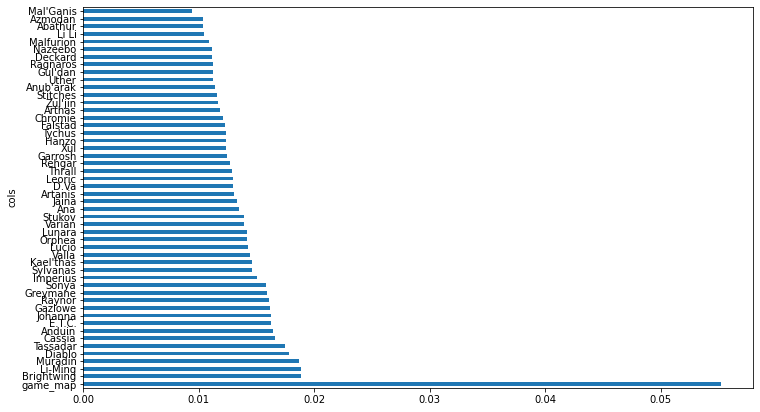

In [42]:
fi = rf_feat_importance(m, df_trn); fi[:10]
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:50]);

In [43]:
#to_keep = fi[fi.imp>0.005].cols; len(to_keep)
#df_keep = df_trn[to_keep].copy()
#X_train, X_valid = split_vals(df_keep, n_trn)

checking how correlated the features are:

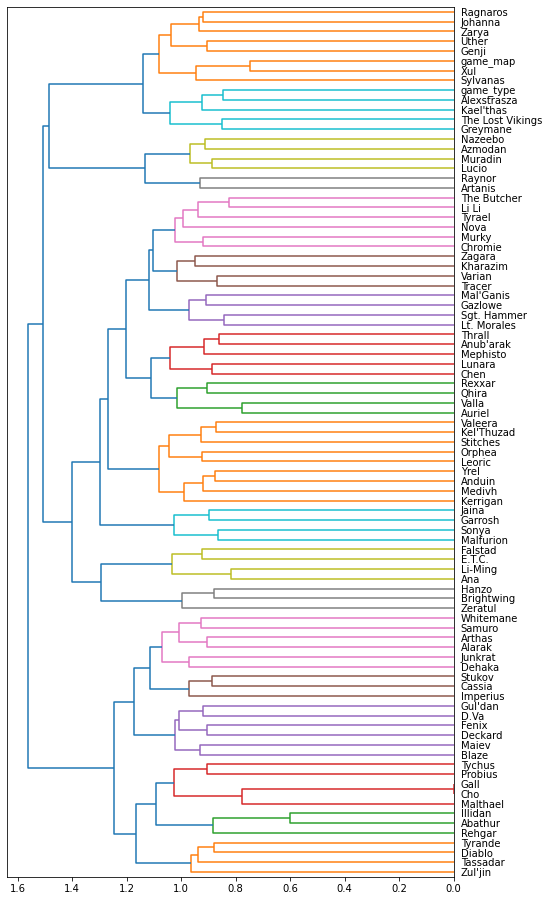

In [44]:
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(df_trn).correlation, 3)
corr_condensed = hc.distance.squareform(pow((1-corr), 3))
z = hc.linkage(corr_condensed, method='complete')
fig = plt.figure(figsize=(8,16))
dendrogram = hc.dendrogram(z, labels=df_trn.columns, orientation='left', leaf_font_size=10)
plt.show()

ggplot(df, aes())+stat_smooth() is a very powerfull graphics lib, coming from R
use get_sample(df, n) to decrease complexity of graph
https://forums.fast.ai/t/unofficial-lesson-4-classnotes/7569
pdp - partial dependence plot library

since the data is patch dependent, it would be better to weight recent matches more whent training. most modeling algorithms can be adjusted via some weight constant

In [45]:
from treeinterpreter import treeinterpreter as ti
row = X_valid.values[None,0]; row
df_train, df_valid = split_vals(dummies_data, n_trn)

In [46]:
#test if tree is properly interpreted
#prediction, bias, contributions = ti.predict(m, row)
#idxs = np.argsort(contributions[0])
#[(a, b, c) for (a, b, c) in zip(dummies_data.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])  if (a in ['game_map', 'game_type'] or b != 0)]

Try interpret a custom data input:

In [47]:
def prognoses(model, game_map, game_type, winners, losers):
    input_row = np.asarray([hero_hot_transform(game_map = game_map, game_type=game_type, winners = winners, losers=losers)])
    prediction, bias, contributions_input = ti.predict(model, input_row)
    idxs = np.argsort(contributions_input[0])
    interpretations = [(a, b, c) for (a, b, c) in zip(dummies_data.columns[idxs], input_row[0][idxs], contributions_input[0][idxs])  if b != 0]
    rest = [(a, b, c) for (a, b, c) in zip(dummies_data.columns[idxs], input_row[0][idxs], contributions_input[0][idxs])  if b == 0]

    change = sum([c for c in contributions_input[0][idxs]])

    outcome = bias[0] + change
    #print(interpretations)
    #print(bias, change, [c for (a, b, c) in interpretations])
    if bias[0] + change > 0.5:
        print("your team is expected to win (>0.5): ",outcome)
    else:
        print("your team is expected to lose (<0.5): ",outcome)
    return (bias, interpretations, rest)
#this is wrong, because I zip wrong things, so values are right, but titles are not

In [48]:
#make a function to draw two waterfalls side by side, one for each team
#https://github.com/chrispaulca/waterfall/blob/master/Tree_interpreter_Example.ipynb
#https://github.com/chrispaulca/waterfall
import waterfall_chart

def draw_interpretation_waterfalls(bias, interpretations, rest):
    winner_team_interps = [(a, b, c) for (a, b, c) in interpretations if (a in hero_names and b == 2)]
    loser_team_interps = [(a, b, c) for (a, b, c) in interpretations if (a in hero_names and b == 1)]

    colnames_winner = [a for (a, b, c) in winner_team_interps]
    colnames_loser = [a for (a, b, c) in loser_team_interps]
    conts_winner = [c for (a, b, c) in winner_team_interps]
    conts_loser = [c for (a, b, c) in loser_team_interps]
    
    colname_totals = ['bias','your team', 'opponents','map','type', 'rest']
    map_interp = [c for (a, b, c) in interpretations if (a == 'game_map')]
    type_interp = [c for (a, b, c) in interpretations if (a == 'game_type')]
    rest_interp = [c for (a, b, c) in rest]
    conts_totals = [bias[0],sum(conts_winner),sum(conts_loser), sum(map_interp), sum(type_interp), sum(rest_interp)]

    winner_plot = waterfall_chart.plot(colnames_winner,conts_winner, rotation_value=90, threshold=0.0,formatting='{:,.4f}')
    loser_plot = waterfall_chart.plot(colnames_loser,conts_loser, rotation_value=90, threshold=0.0,formatting='{:,.4f}')
    totals_plot = waterfall_chart.plot(colname_totals,conts_totals, rotation_value=90, threshold=0.0,formatting='{:,.4f}')

#conts = [contributions_input[0][i] for i in range(len(contributions_input[0]))]
#colnames = dummies_data.columns[0:-1].values
#my_plot = waterfall_chart.plot(colnames,conts, rotation_value=90, threshold=0.1,formatting='{:,.3f}')

set inputs:

In [49]:
map_names

Index(['Alterac Pass', 'Battlefield of Eternity', 'Blackheart's Bay',
       'Braxis Holdout', 'Cursed Hollow', 'Dragon Shire', 'Garden of Terror',
       'Hanamura Temple', 'Infernal Shrines', 'Sky Temple',
       'Tomb of the Spider Queen', 'Towers of Doom', 'Volskaya Foundry',
       'Warhead Junction'],
      dtype='object')

In [50]:
#print hero names, to copy exactly:
hero_names

Index(['Abathur', 'Alarak', 'Alexstrasza', 'Ana', 'Anduin', 'Anub'arak',
       'Artanis', 'Arthas', 'Auriel', 'Azmodan', 'Blaze', 'Brightwing',
       'Cassia', 'Chen', 'Cho', 'Chromie', 'D.Va', 'Deckard', 'Dehaka',
       'Diablo', 'E.T.C.', 'Falstad', 'Fenix', 'Gall', 'Garrosh', 'Gazlowe',
       'Genji', 'Greymane', 'Gul'dan', 'Hanzo', 'Illidan', 'Imperius', 'Jaina',
       'Johanna', 'Junkrat', 'Kael'thas', 'Kel'Thuzad', 'Kerrigan', 'Kharazim',
       'Leoric', 'Li Li', 'Li-Ming', 'Lt. Morales', 'Lucio', 'Lunara', 'Maiev',
       'Mal'Ganis', 'Malfurion', 'Malthael', 'Medivh', 'Mephisto', 'Muradin',
       'Murky', 'Nazeebo', 'Nova', 'Orphea', 'Probius', 'Qhira', 'Ragnaros',
       'Raynor', 'Rehgar', 'Rexxar', 'Samuro', 'Sgt. Hammer', 'Sonya',
       'Stitches', 'Stukov', 'Sylvanas', 'Tassadar', 'The Butcher',
       'The Lost Vikings', 'Thrall', 'Tracer', 'Tychus', 'Tyrael', 'Tyrande',
       'Uther', 'Valeera', 'Valla', 'Varian', 'Whitemane', 'Xul', 'Yrel',
       'Zagara', 'Za

In [51]:
game_map = 'Tomb of the Spider Queen'
game_type = 'UnrankedDraft'
your_team=['Brightwing', "Kael'thas", 'Leoric', "Qhira", 'Malthael']
opponent_tea=['Johanna', 'Malfurion', 'Azmodan', 'Kerrigan', 'Blaze']

calculate and draw out match prognosis:

In [52]:
bias, prog, rest = prognoses(m, game_map, game_type, your_team, opponent_tea)

your team is expected to win (>0.5):  0.55


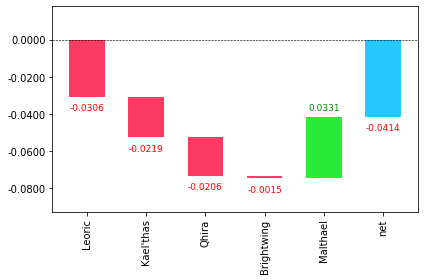

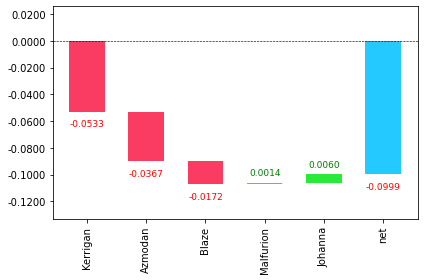

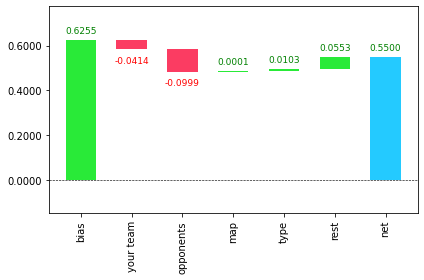

In [53]:
draw_interpretation_waterfalls(bias, prog ,rest)

In [54]:
input_row = np.asarray([hero_hot_transform(game_map = game_map, game_type=game_type, winners = your_team, losers=opponent_tea)])
prediction = m.predict(input_row)
print(prediction)

[0.55]


# XGBoost part

In [55]:
import xgboost
my_model_2 = xgboost.XGBRegressor(random_state=0, learning_rate = 0.2, n_estimators = 200)
xgb_weights = pd.Series(np.linspace(0.5, 1, sample_size))

In [56]:
%time my_model_2.fit(X_train, y_train, sample_weight_eval_set = xgb_weights, verbose=False) # , early_stopping_rounds=5, eval_set=[(X_valid, y_valid)] # throws assersion error
print_score(my_model_2)

CPU times: user 4.51 s, sys: 38 ms, total: 4.55 s
Wall time: 1.82 s
[0.1834230765198316, 0.6170944012061688, 0.8564521599999999, 0.0]


In [57]:
#import matplotlib.pylab as pl
#plt.rcParams["figure.figsize"] = (10, 15)
#xgboost.plot_importance(my_model_2, height=0.75, importance_type="gain") #, max_num_features=20
#pl.title("xgboost.plot_importance(model)")
#pl.show()

In [58]:
import shap
explainer = shap.TreeExplainer(my_model_2)
shap_values = explainer.shap_values(df_trn)

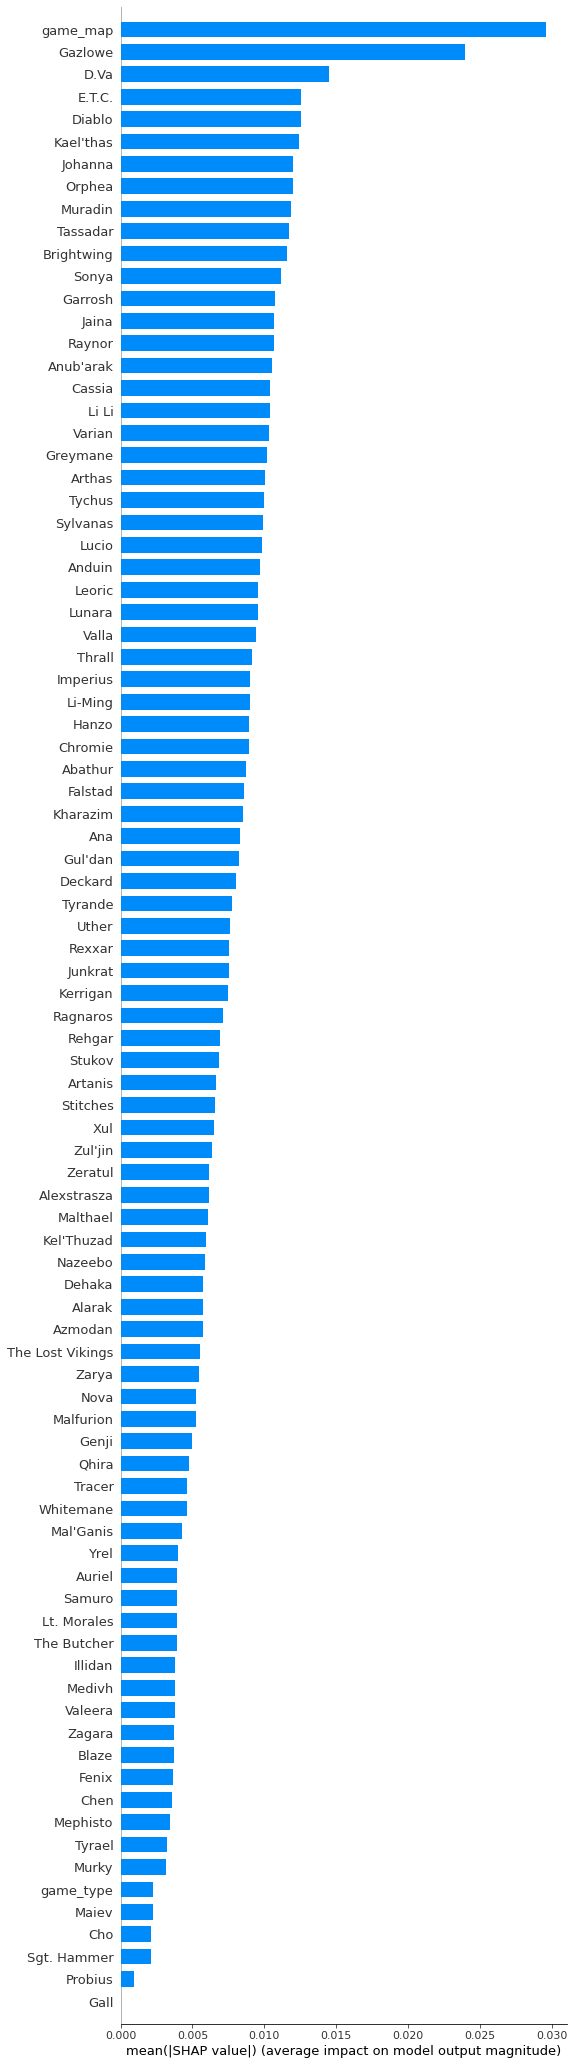

In [59]:
shap.summary_plot(shap_values, X_train, plot_type="bar",max_display=X_train.shape[1]) #scrollable
#shap.summary_plot(shap_values[:,5:6], X.iloc[:, 5:6])

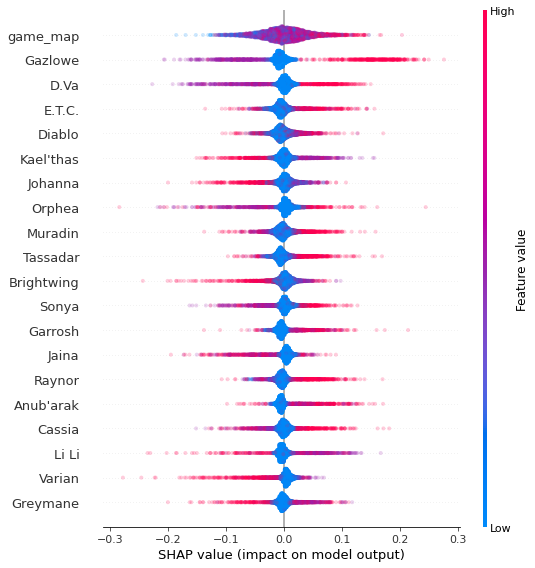

In [60]:
shap.summary_plot(shap_values, df_trn,alpha=0.2)

In [61]:
?shap.summary_plot

In [62]:
shap.initjs()

In [188]:
#to visualize single prediction with XGBoost use: shap:  https://slundberg.github.io/shap/notebooks/Census%20income%20classification%20with%20XGBoost.html
#shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])
input_row = np.asarray([hero_hot_transform(game_map = game_map, game_type=game_type, winners = winners, losers=losers)])
row_input = 1564
#feat_filter = X_train.iloc[row_input,:].columns[(df == 1).any(axis=0)]
features = X_train.iloc[row_input,:]
feature_names = X_train.columns
shap.force_plot(explainer.expected_value, shap_values=shap_values[row_input,:], features=features,feature_names=feature_names,text_rotation=-45)
#How to show the concrete game??? output changes when shap_values[] indexer is changed... but does it input new vals? How to omit zeroes?

In [181]:
?shap.force_plot

In [179]:
shap.force_plot(explainer.expected_value, shap_values[1800:2000,:], X_train.iloc[1800:2000,:])

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


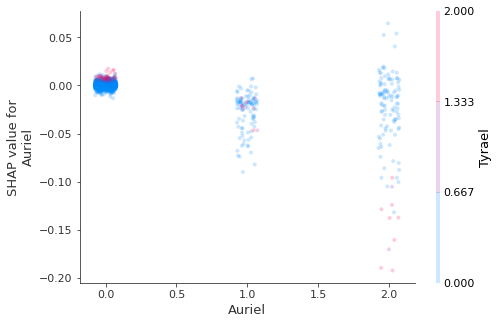

In [68]:
#this doesnt show anything usefull..
slice_size = int(sample_size / 2)
shap.dependence_plot("Auriel", shap_values[slice_size:], df_trn[slice_size:], display_features=X_train, x_jitter = 0.15, alpha = 0.2)

In [ ]:
#?shap.dependence_plot

In [71]:
my_model_2.save_model("exports/model_1.xgboost")

In [93]:
game_map = 'Tomb of the Spider Queen'
game_type = 'UnrankedDraft'
your_team=['Brightwing', "Kael'thas", 'Leoric', "Qhira", 'Malthael']
opponent_tea=['Johanna', 'Malfurion', 'Azmodan', 'Kerrigan', 'Blaze']

In [109]:
input_row = pd.DataFrame(hero_hot_transform(game_map = game_map, game_type=game_type, winners = your_team, losers=opponent_tea)).transpose()
print(input_row)

   Abathur  Alarak  Alexstrasza  Ana  Anduin  Anub'arak  Artanis  Arthas  \
0        0       0            0    0       0          0        0       0   

   Auriel  Azmodan  ...  Varian  Whitemane  Xul  Yrel  Zagara  Zarya  Zeratul  \
0       0        1  ...       0          0    0     0       0      0        0   

   Zul'jin  game_map  game_type  
0        0        10          1  

[1 rows x 89 columns]


In [110]:
prediction = my_model_2.predict(input_row)
print(prediction)

[0.53593]


In [175]:
type(prediction)

numpy.ndarray

In [169]:
feature_names = dict(enumerate(X_train.columns))
game_map_cats = dict(enumerate(df_mixed['game_map'].cat.categories))
game_type_cats = dict(enumerate(df_mixed['game_type'].cat.categories))
hero_name_cats = dict(enumerate(df_mixed['winnerA'].cat.categories))

In [170]:
import csv
def save_dict(file_name, dict_obj):
    w = csv.writer(open(file_name, "w+"))
    for key, val in dict_obj.items():
        w.writerow([key, val])

In [171]:
save_dict("exports/feature_names.csv", feature_names)
save_dict("exports/game_map_cats.csv", game_map_cats)
save_dict("exports/game_type_cats.csv", game_type_cats)
save_dict("exports/hero_name_cats.csv", hero_name_cats)

In [154]:
m_names = pd.read_csv("exports/game_map_cats.csv",header=None, index_col=0, squeeze=True).to_dict()
gt_names = pd.read_csv("exports/game_type_cats.csv",header=None, index_col=0, squeeze=True).to_dict()

m_names_swapped = dict([(value, key) for key, value in m_names.items()])
gt_names_swapped = dict([(value, key) for key, value in gt_names.items()])

In [164]:
def hero_hot_transform_xgb(game_map = '', game_type = 'UnrankedDraft', winners = [], losers = [], bans = []):
    new_row = pd.Series(index = hero_names, dtype = 'int8')
    for x in hero_names:
        if x in winners:
            new_row[x] = 2
        if x in losers:
            new_row[x] = 1
    game_map_index = m_names_swapped[game_map]
    game_type_index = gt_names_swapped[game_type]        

    new_row = new_row.append(pd.Series([game_map_index, game_type_index], index = ['game_map','game_type']))
    return new_row

In [165]:
input_row = pd.DataFrame(hero_hot_transform_xgb(game_map = game_map, game_type=game_type, winners = your_team, losers=opponent_tea)).transpose()
print(input_row)

   Abathur  Alarak  Alexstrasza  Ana  Anduin  Anub'arak  Artanis  Arthas  \
0        0       0            0    0       0          0        0       0   

   Auriel  Azmodan  ...  Varian  Whitemane  Xul  Yrel  Zagara  Zarya  Zeratul  \
0       0        1  ...       0          0    0     0       0      0        0   

   Zul'jin  game_map  game_type  
0        0        10          1  

[1 rows x 89 columns]


In [172]:
list(m_names_swapped.keys())[0]

AttributeError: 'str' object has no attribute 'dtypes'